## COVID-19 (mortality and recovery analysis and EDA)

In [1]:
# storing and analysis
import numpy as np
import pandas as pd
#visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
#Calculation and statistic  
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
confirm_df= pd.read_csv('./time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('./time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('./time_series_covid19_recovered_global.csv')

In [3]:
pd.set_option('display.max_column', None)
confirm_df.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219


In [4]:
cols=confirm_df.keys()

In [5]:
confirmed = confirm_df.loc[:, cols[4]:cols[-2]]
deaths = death_df.loc[:, cols[4]:cols[-2]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-2]]

In [6]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases = [] 
italy_cases = []
us_cases = [] 

for i in dates:
    confirmed_sum=confirmed[i].sum()
    death_sum=deaths[i].sum()
    recovery_sum=recoveries[i].sum()
    
    #confirmed(確診), deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovery_sum)
    total_active.append(confirmed_sum-death_sum-recovery_sum)
    
    #計算rates
    #致死率和回復率
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovery_sum/confirmed_sum)
    
    # case studies (個案研究)
    china_cases.append(confirm_df[confirm_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirm_df[confirm_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirm_df[confirm_df['Country/Region']=='US'][i].sum())

In [7]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1,1)
world_cases=np.array(world_cases).reshape(-1,1)
total_deaths=np.array(total_deaths).reshape(-1,1)
total_recovered= np.array(total_recovered).reshape(-1,1)

In [8]:
# Future forcasting(未來預測)
day_in_future=10
future_forcast = np.array([i for i in range(len(dates)+day_in_future)]).reshape(-1,1)
adjusted_dates= future_forcast[:-10]

In [9]:
#將整數轉換為日期時間以獲得更好的視覺化
start='1/22/2020'
start_date= datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates=[]
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date+datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [10]:
#做資料切割(condirmed)
X_train, X_test, y_train, y_test=train_test_split(days_since_1_22, world_cases, test_size=.2, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51, 1), (13, 1), (51, 1), (13, 1))

In [11]:
#製作預測確診個案模型，並使用support vector machine, bayesian ridge , and linear regression
#use this to find the optimal parameters for SVR
#c = [0.01, 0.1, 1]
#gamma = [0.01, 0.1, 1]
#epsilon = [0.01, 0.1, 1]
#shrinking = [True, False]
#degree = [3, 4, 5]

#svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

#svm = SVR(kernel='poly')
#svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
#svm_search.fit(X_train, y_train)
#svm_search.best_params_

In [12]:
svm_confirmed= SVR(shrinking=True, kernel='poly', gamma=.01, epsilon=1, degree=6, C=.1)
svm_confirmed.fit(X_train, y_train)
svm_pred=svm_confirmed.predict(future_forcast)

MAE value: 28909.249632788273
MSE value: 920080801.1554927


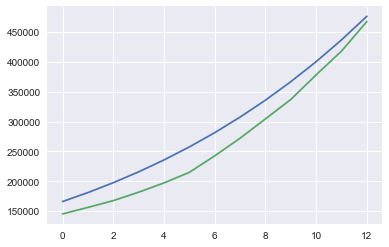

In [13]:
# 檢查測試數據，看MAE 跟 MSE
svm_test_pred=svm_confirmed.predict(X_test)
plt.plot(svm_test_pred)
plt.plot(y_test)
print('MAE value:', mean_absolute_error(svm_test_pred, y_test))
print('MSE value:', mean_squared_error(svm_test_pred, y_test))

In [14]:
#轉換data 來進行polynomial regression
poly= PolynomialFeatures(degree=5)
poly_X_train=poly.fit_transform(X_train)
poly_X_test=poly.fit_transform(X_test)
poly_future_forcast= poly.fit_transform(future_forcast)

In [15]:
#polynomial regression
linear_model= LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train,y_train)
test_linear_pred=linear_model.predict(poly_X_test)
linear_pred=linear_model.predict(poly_future_forcast)
print('MAE value:', mean_absolute_error(test_linear_pred, y_test))
print('MSE value:', mean_squared_error(test_linear_pred, y_test))
print(linear_model.coef_)

MAE value: 19416.43816171872
MSE value: 732832606.1286621
[[ 2.89914006e+03 -1.96103299e+03  3.96280956e+02 -9.73739770e+00
   1.27179482e-02  1.19979443e-03]]


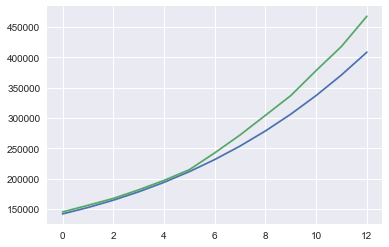

In [16]:
plt.plot(test_linear_pred)
plt.plot(y_test)

In [17]:
#貝氏分析 (bayesian ridge regression)
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}
#bayesian ridge polynomial regression
bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', 
                                     cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.3s finished


RandomizedSearchCV(cv=3,
                   estimator=BayesianRidge(fit_intercept=False, normalize=True),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'tol': [0.0001, 0.001, 0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [18]:
bayesian_search.best_params_

{'tol': 0.0001,
 'lambda_2': 0.0001,
 'lambda_1': 0.0001,
 'alpha_2': 1e-05,
 'alpha_1': 1e-05}

In [19]:
bayesian_confirmed= bayesian_search.best_estimator_
test_bayesian_pred= bayesian_confirmed.predict(poly_X_test)
bayesian_pred= bayesian_confirmed.predict(poly_future_forcast)
print('MAE value:', mean_absolute_error(test_bayesian_pred, y_test))
print('MSE value:', mean_squared_error(test_bayesian_pred, y_test))

MAE value: 16042.179007383584
MSE value: 356844190.8989538


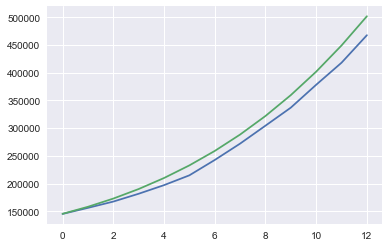

In [20]:
plt.plot(y_test)
plt.plot(test_bayesian_pred)

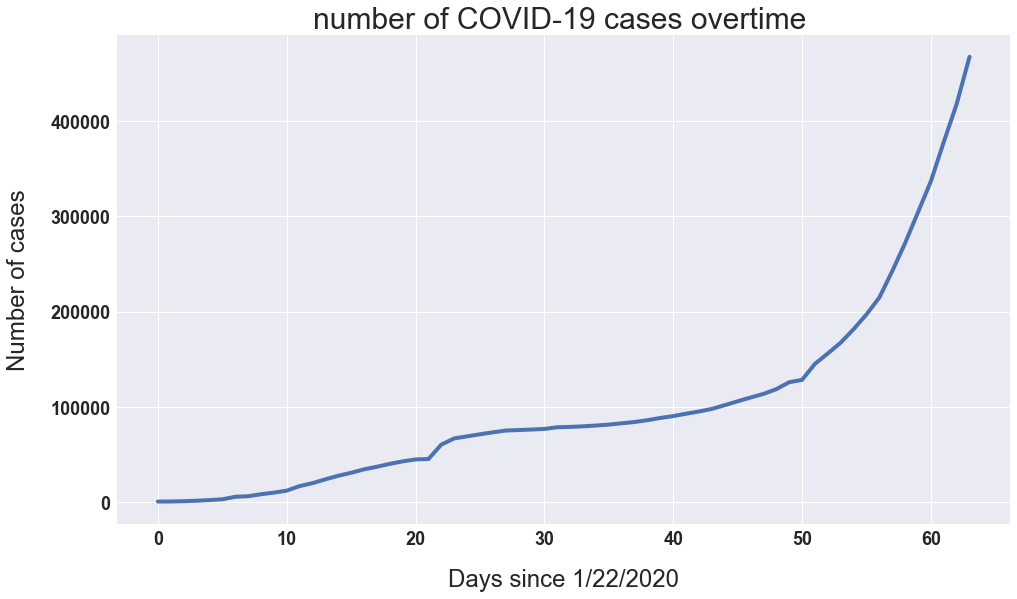

In [21]:
#做出確診病例數，活動病例數，死亡，康復，死亡率和康復率的圖表
'''
label: 標籤文字
fontdict: 標籤文字字型字典，例如字型系列、顏色、粗細和大小
labelpad: 標籤和 x or y 軸之間的間距
linewidth 或 lw: 線寬，以 points 為單位
'''
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, world_cases, lw=4)
plt.title('number of COVID-19 cases overtime ', size=30)
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Number of cases', labelpad = 20, size=24)
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

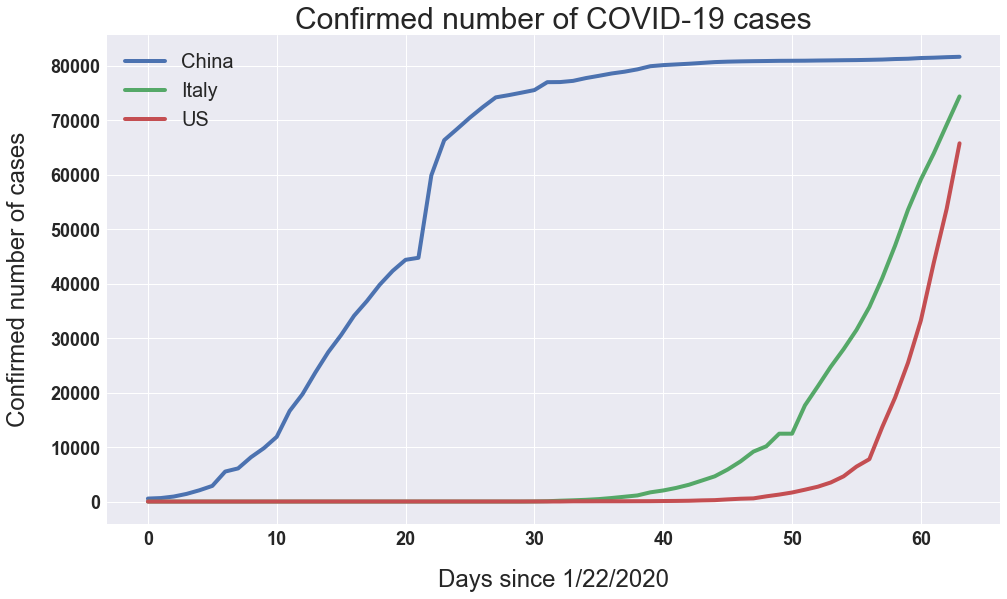

In [22]:
#COVID-19 case confirmed in China, Italy, US
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, china_cases, lw=4)
plt.plot(adjusted_dates, italy_cases, lw=4)
plt.plot(adjusted_dates, us_cases, lw=4)
plt.title('Confirmed number of COVID-19 cases', size=30)
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Confirmed number of cases', labelpad = 20, size=24)
plt.legend(['China', 'Italy', 'US'], prop={'size': 20})
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

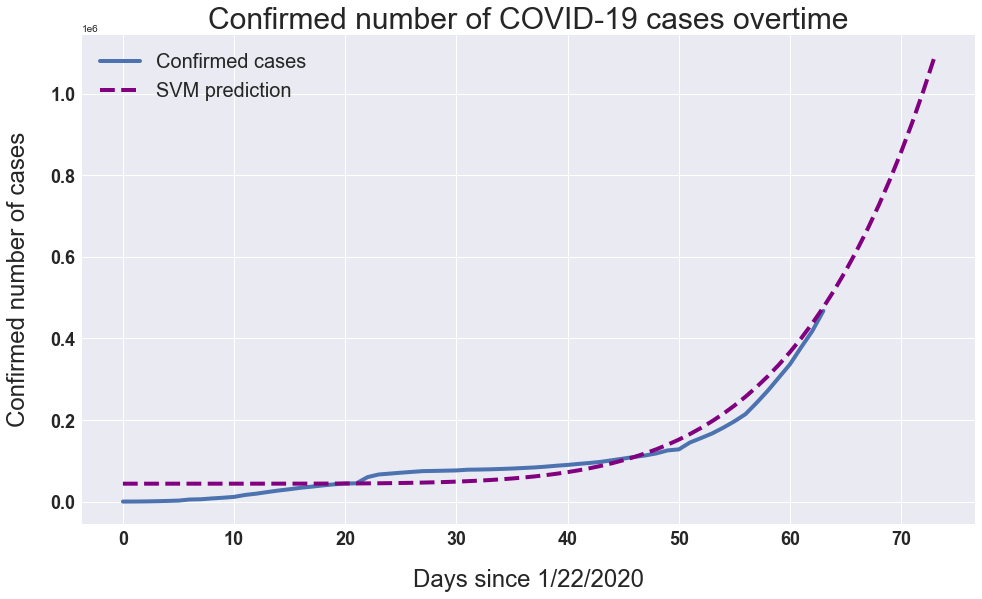

In [23]:
#SVM preidction
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, world_cases,lw=4)
plt.plot(future_forcast,svm_pred, linestyle='--', color='purple', lw=4)
plt.title('Confirmed number of COVID-19 cases overtime', size=30)
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Confirmed number of cases', labelpad = 20, size=24)
plt.legend(['Confirmed cases', 'SVM prediction'], prop={'size': 20})
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

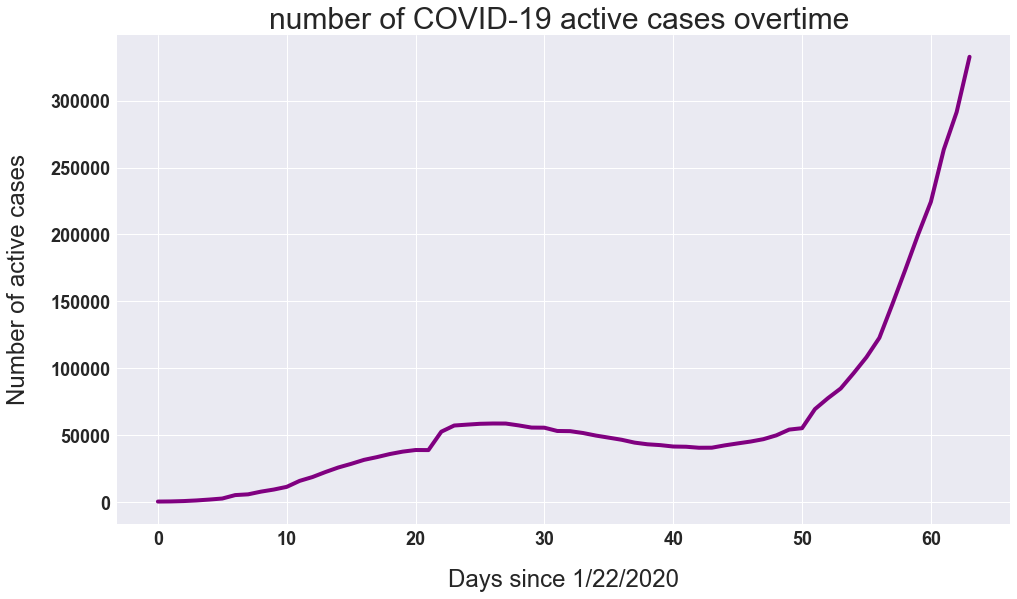

In [24]:
#active death and recovary case
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, total_active, color='purple', lw=4)
plt.title('number of COVID-19 active cases overtime ', size=30)
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Number of active cases', labelpad = 20, size=24)
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

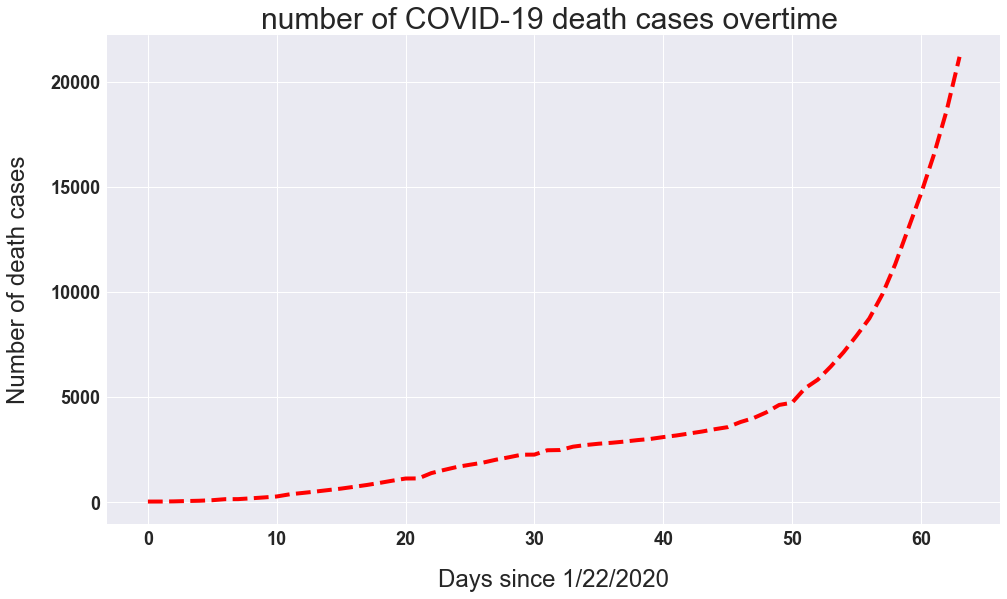

In [25]:
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates,total_deaths, linestyle='--', color='red', lw=4)
plt.title('number of COVID-19 death cases overtime ', size=30)
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Number of death cases', labelpad = 20, size=24)
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

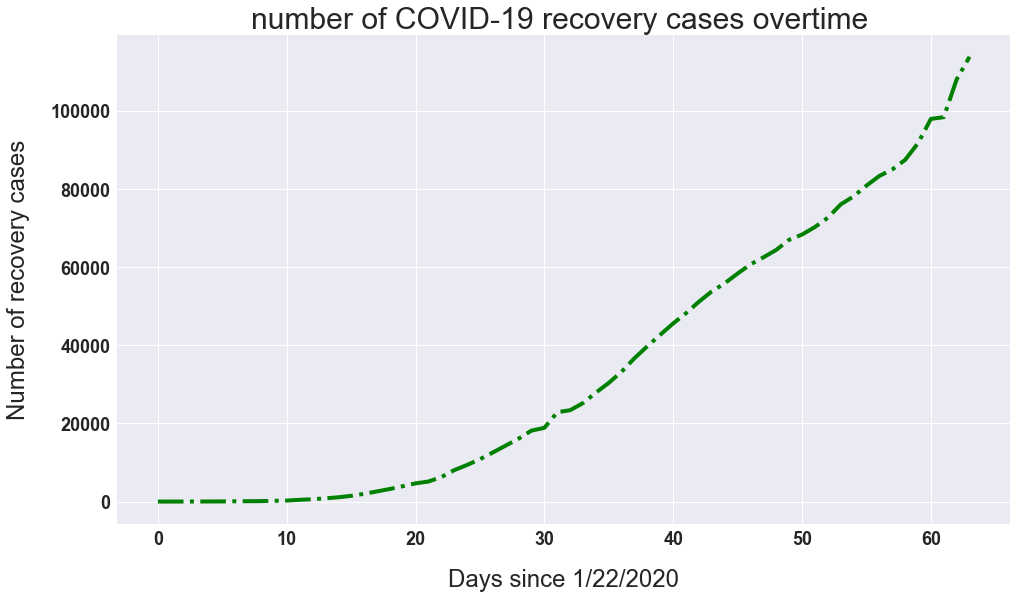

In [26]:
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates,total_recovered, linestyle='-.', color='green', lw=4)
plt.title('number of COVID-19 recovery cases overtime ', size=30)
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Number of recovery cases', labelpad = 20, size=24)
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

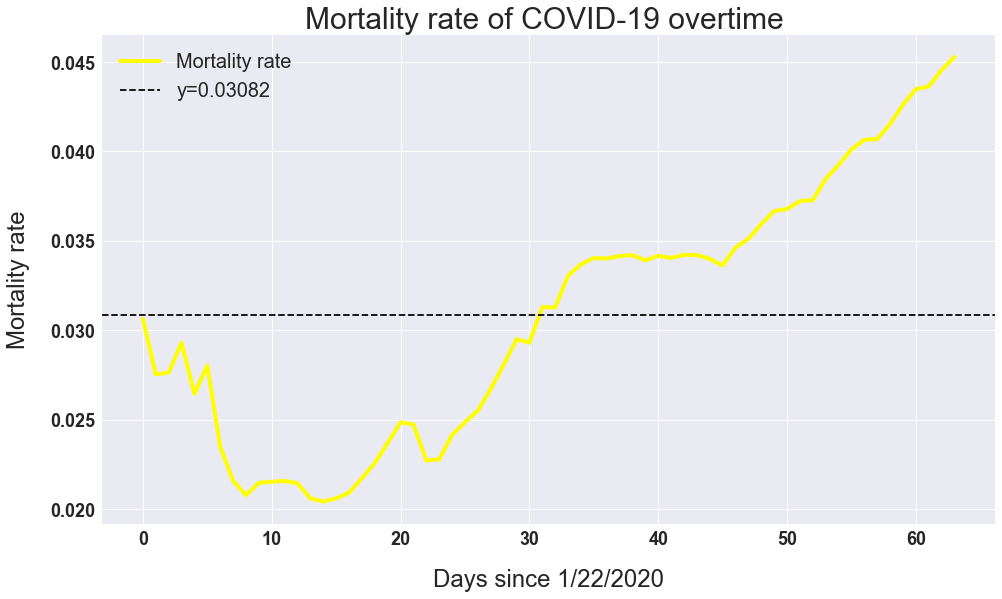

In [27]:
mean_mortality_rate = round(np.mean(mortality_rate),5)
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, mortality_rate, color='yellow', lw=4)
plt.axhline(y=mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality rate of COVID-19 overtime ', size=30)
plt.legend(['Mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Mortality rate', labelpad = 20, size=24)
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

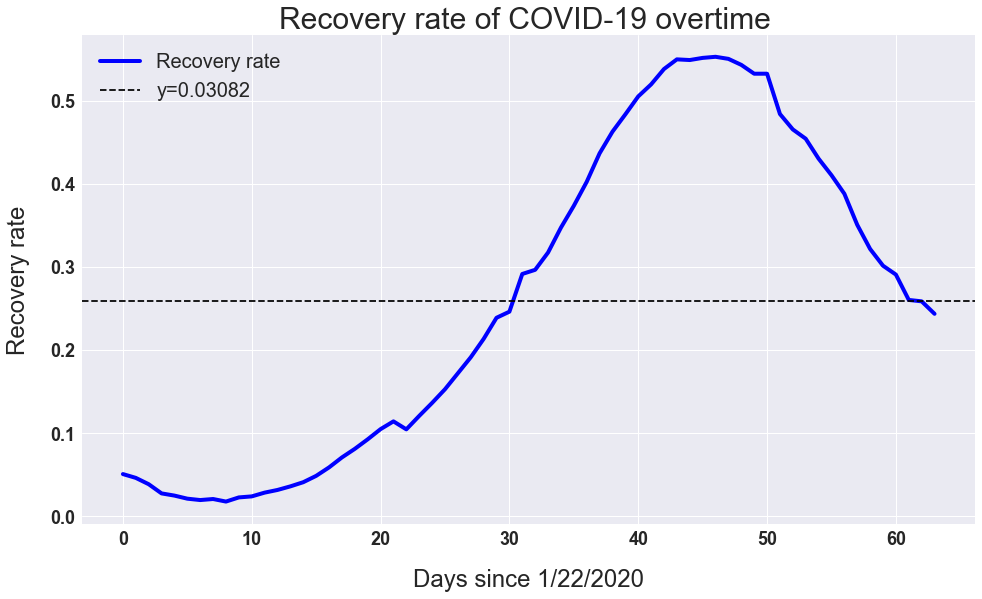

In [28]:
mean_recovery_rate = round(np.mean(recovery_rate),5)
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, recovery_rate, color='blue', lw=4)
plt.axhline(y=mean_recovery_rate, linestyle='--', color='black')
plt.title('Recovery rate of COVID-19 overtime ', size=30)
plt.legend(['Recovery rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days since 1/22/2020', labelpad = 20, size=24)
plt.ylabel('Recovery rate', labelpad = 20, size=24)
plt.xticks(size=18, fontweight = "bold")
plt.yticks(size=18, fontweight = "bold")
plt.show()

In [29]:
# Exploratory Data Analysis(EDA) 計算
confirmed_df=pd.read_csv('./new.csv')
pd.set_option('display.max_column', None)
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19


In [30]:
death_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
df1=confirmed_df.drop('Province/State', axis=1)

In [32]:
'''
使用groupby()方法可以將資料依照自己要的column分組
，Country/Region用的內容做分組的依據，並存到變數內
DataFrame.sort_values(by, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
ascending这个参数的默认值是True，按照升序排序，当传入False时，按照降序进行排列
'''
#因為 death data 統計到 3/26/20 所以要把confirm_df 做群組
df2=df1.groupby(by='Country/Region').sum().sort_values('3/26/20', ascending=False)
df2.head(20)

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,37.0902,-95.7129,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783,13747,19273,25600,33276,43843,53736,65778,83836,101657,121465,140909,161831,188172,213372,243762,275586,308853,337072,366667,396223,429052,461437,496535,526396,555313,580619,607670,636350,667801,699706
China,1083.3367,3684.4197,548,643,920,1406,2075,2877,5509,6087,8141,9802,11891,16630,19716,23707,27440,30587,34110,36814,39829,42354,44386,44759,59895,66358,68413,70513,72434,74211,74619,75077,75550,77001,77022,77241,77754,78166,78600,78928,79356,79932,80136,80261,80386,80537,80690,80770,80823,80860,80887,80921,80932,80945,80977,81003,81033,81058,81102,81156,81250,81305,81435,81498,81591,81661,81782,81897,81999,82122,82198,82279,82361,82432,82511,82543,82602,82665,82718,82809,82883,82941,83014,83134,83213,83306,83356,83403,83760
Italy,43.0000,12.0000,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138,63927,69176,74386,80589,86498,92472,97689,101739,105792,110574,115242,119827,124632,128948,132547,135586,139422,143626,147577,152271,156363,159516,162488,165155,168941,172434
Spain,40.0000,-4.0000,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,6,13,15,32,45,84,120,165,222,259,400,500,673,1073,1695,2277,2277,5232,6391,7798,9942,11748,13910,17963,20410,25374,28768,35136,39885,49515,57786,65719,73235,80110,87956,95923,104118,112065,119199,126168,131646,136675,141942,148220,153222,158273,163027,166831,170099,172541,177644,184948,190839
Germany,51.0000,9.0000,0,0,0,0,0,1,4,4,4,5,8,10,12,12,12,12,13,13,14,14,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,27,46,48,79,130,159,196,262,482,670,799,1040,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873,29056,32986,37323,43938,50871,57695,62095,66885,71808,77872,84794,91159,96092,100123,103374,107663,113296,118181,122171,124908,127854,130072,131359,134753,137698,141397
France,91.3624,59.7192,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,57,100,130,191,204,288,380,656,959,1136,1219,1794,2293,2293,3681,4496,4532,6683,7715,9124,10970,12758,14463,16243,20123,22622,25600,29551,33402,38105,40708,45170,52827,57749,59929,65202,69500,71412,75343,79163,83057,87366,91738,94863,121712,125394,131361,134582,147091,149130
Iran,32.0000,53.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,18,28,43,61,95,139,245,388,593,978,1501,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638,23049,24811,27017,29406,32332,35408,38309,41495,44605,47593,50468,53183,55743,58226,60500,62589,64586,66220,68192,70029,71686,73303,74877,76389,77995,79494
United Kingdom,270.0299,-482.9247,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,13,13,15,20,23,36,40,51,86,116,164,207,274,322,384,459,459,802,1144,1145,1551,1960,2642,2716,4014,5067,5745,6726,8164,9640,11812,14745,17312,19780,22453,25481,29865,34173,38689,42477,48436

In [33]:
#選前20個並delete 'lat', 'long'
top_N=20
df3=df2.iloc[:top_N+1]
for col in ['Lat','Long']:
    df3.drop(col, inplace=True, axis=1)
df3=df3[df3.index !='China'] # != 相當於 ==
df3

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783,13747,19273,25600,33276,43843,53736,65778,83836,101657,121465,140909,161831,188172,213372,243762,275586,308853,337072,366667,396223,429052,461437,496535,526396,555313,580619,607670,636350,667801,699706
Italy,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138,63927,69176,74386,80589,86498,92472,97689,101739,105792,110574,115242,119827,124632,128948,132547,135586,139422,143626,147577,152271,156363,159516,162488,165155,168941,172434
Spain,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,6,13,15,32,45,84,120,165,222,259,400,500,673,1073,1695,2277,2277,5232,6391,7798,9942,11748,13910,17963,20410,25374,28768,35136,39885,49515,57786,65719,73235,80110,87956,95923,104118,112065,119199,126168,131646,136675,141942,148220,153222,158273,163027,166831,170099,172541,177644,184948,190839
Germany,0,0,0,0,0,1,4,4,4,5,8,10,12,12,12,12,13,13,14,14,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,27,46,48,79,130,159,196,262,482,670,799,1040,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873,29056,32986,37323,43938,50871,57695,62095,66885,71808,77872,84794,91159,96092,100123,103374,107663,113296,118181,122171,124908,127854,130072,131359,134753,137698,141397
France,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,57,100,130,191,204,288,380,656,959,1136,1219,1794,2293,2293,3681,4496,4532,6683,7715,9124,10970,12758,14463,16243,20123,22622,25600,29551,33402,38105,40708,45170,52827,57749,59929,65202,69500,71412,75343,79163,83057,87366,91738,94863,121712,125394,131361,134582,147091,149130
Iran,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,18,28,43,61,95,139,245,388,593,978,1501,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638,23049,24811,27017,29406,32332,35408,38309,41495,44605,47593,50468,53183,55743,58226,60500,62589,64586,66220,68192,70029,71686,73303,74877,76389,77995,79494
United Kingdom,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,13,13,15,20,23,36,40,51,86,116,164,207,274,322,384,459,459,802,1144,1145,1551,1960,2642,2716,4014,5067,5745,6726,8164,9640,11812,14745,17312,19780,22453,25481,29865,34173,38689,42477,48436,52279,55949,61474,65872,74605,79874,85206,89570,94845,99483,104145,109769
Switzerland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,8,18,27,42,56,90,114,214,268,337,374,491,652,652,1139,1359,2200,2200,2700,3028,4075,5294,6575,7474,8795,9877,10897,11811,12928,14076,14829,15922,16605,17768,18827,19606,20505,21100,21657,22253,23280,24051,24551,25107,25415,25688,25936,26336,26732,27078
"Korea, South",1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,3736,4335,5186,5621,6088,6593,7041,7314,7478,7513,7755,7869,7979,8086,8162,8236,8320,8413,8565,8652,8799,8961,

In [34]:
data_list=[]
country_list=df3.index
first_day=[0 for _ in range(top_N)]

for i in range(top_N):
    #取每個國家第一天>0
    for col in range(0, len(df3.columns)):
        if df3.iloc[i, col]>50:
            first_day[i]=col
            break
            
for i in range(top_N):
    data_list.append([])
    for col in range(first_day[i], len(df3.columns)):
        data_list[i].append(df3.iloc[i,col])
        
df=pd.DataFrame(data_list)
df.index=country_list
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783,13747,19273,25600,33276,43843,53736,65778,83836.0,101657.0,121465.0,140909.0,161831.0,188172.0,213372.0,243762.0,275586.0,308853.0,337072.0,366667.0,396223.0,429052.0,461437.0,496535.0,526396.0,555313.0,580619.0,607670.0,636350.0,667801.0,699706.0,NaN,NaN,NaN,NaN
Italy,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138,63927,69176.0,74386.0,80589.0,86498.0,92472.0,97689.0,101739.0,105792.0,110574.0,115242.0,119827.0,124632.0,128948.0,132547.0,135586.0,139422.0,143626.0,147577.0,152271.0,156363.0,159516.0,162488.0,165155.0,168941.0,172434.0,NaN,NaN
Spain,84,120,165,222,259,400,500,673,1073,1695,2277,2277,5232,6391,7798,9942,11748,13910,17963,20410,25374,28768,35136,39885,49515,57786,65719,73235,80110,87956,95923,104118.0,112065.0,119199.0,126168.0,131646.0,136675.0,141942.0,148220.0,153222.0,158273.0,163027.0,166831.0,170099.0,172541.0,177644.0,184948.0,190839.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Germany,79,130,159,196,262,482,670,799,1040,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873,29056,32986,37323,43938,50871,57695,62095,66885,71808.0,77872.0,84794.0,91159.0,96092.0,100123.0,103374.0,107663.0,113296.0,118181.0,122171.0,124908.0,127854.0,130072.0,131359.0,134753.0,137698.0,141397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
France,57,100,130,191,204,288,380,656,959,1136,1219,1794,2293,2293,3681,4496,4532,6683,7715,9124,10970,12758,14463,16243,20123,22622,25600,29551,33402,38105,40708,45170.0,52827.0,57749.0,59929.0,65202.0,69500.0,71412.0,75343.0,79163.0,83057.0,87366.0,91738.0,94863.0,121712.0,125394.0,131361.0,134582.0,147091.0,149130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iran,61,95,139,245,388,593,978,1501,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638,23049,24811,27017,29406.0,32332.0,35408.0,38309.0,41495.0,44605.0,47593.0,50468.0,53183.0,55743.0,58226.0,60500.0,62589.0,64586.0,66220.0,68192.0,70029.0,71686.0,73303.0,74877.0,76389.0,77995.0,79494.0,NaN,NaN,NaN,NaN
United Kingdom,51,86,116,164,207,274,322,384,459,459,802,1144,1145,1551,1960,2642,2716,4014,5067,5745,6726,8164,9640,11812,14745,17312,19780,22453,25481,29865,34173,38689.0,42477.0,48436.0,52279.0,55949.0,61474.0,65872.0,74605.0,79874.0,85206.0,89570.0,94845.0,99483.0,104145.0,109769.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Switzerland,56,90,114,214,268,337,374,491,652,652,1139,1359,2200,2200,2700,3028,4075,5294,6575,7474,8795,9877,10897,11811,12928,14076,14829,15922,16605,17768,18827,19606.0,20505.0,21100.0,21657.0,22253.0,23280.0,24051.0,24551.0,25107.0,25415.0,25688.0,25936.0,26336.0,26732.0,27078.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Korea, South",104,204,433,602,833,977,1261,1766,2337,3150,3736,4335,5186,5621,6088,6593,7041,7314,7478,7513,7755,7869,7979,8086,8162,8236,8320,8413,8565,8652,8799,8961.0,8961.0,9037.0,9137.0,9241.0,9332.0,9478.0,9583.0,9661.0,9786.0,9887.0,9976.0,10062.0,10156.0,10237.0,10284.0,10331.0,10384.0,10423.0,10450.0,10480.0,10512.0,10537.0,10564.0,10591.0,10613.0,10635.0


In [35]:
#給予圖表註解 並避開 nan
def set_annotate(i):
    if len(df.columns)>60 and not np.isnan(df.iloc[i,60]):
        plt.annotate(df.index[i], (60, df.iloc[i,60]))
    elif len(df.columns)>50 and not np.isnan(df.iloc[i,55]):
        plt.annotate(df.index[i], (55, df.iloc[i,55]))
    elif len(df.columns)>50 and not np.isnan(df.iloc[i,50]):
        plt.annotate(df.index[i], (50, df.iloc[i,50]))

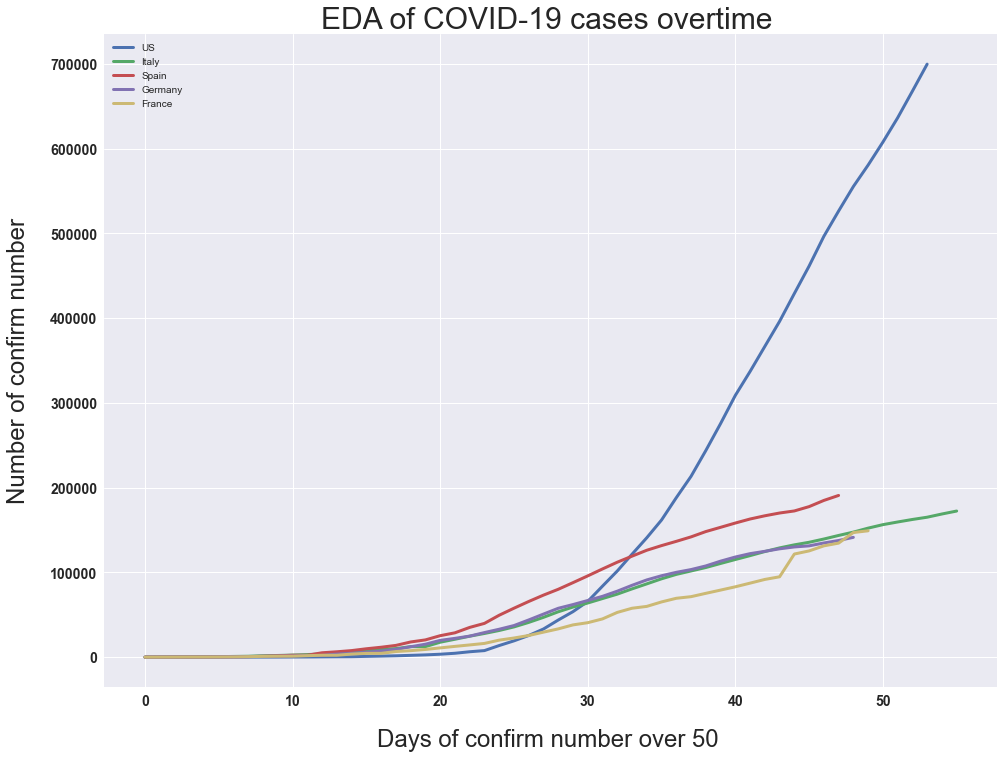

In [36]:
#製圖
plt.figure(figsize=(16,12))
for i in range(5):
    plt.plot(df.iloc[i],lw=3)
    #set annotate
plt.legend(df.index)
plt.title('EDA of COVID-19 cases overtime ', size=30)
plt.xlabel('Days of confirm number over 50 ', labelpad = 20, size=24)
plt.ylabel('Number of confirm number', labelpad = 20, size=24)
plt.xticks(size=14, fontweight = "bold")
plt.yticks(size=14, fontweight = "bold")
plt.show()